In [55]:
%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm


import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat")
data_dir = os.path.abspath("/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data")

from arviz.plots.backends.matplotlib import matplotlib_kwarg_dealiaser

2024-05-30 10:43:06,165 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [13]:

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py

# Only plot for cortical areas
df = df.query(f"structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']")


2024-05-29 15:54:18,387 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_1.1_analysis_metrics.csv
2024-05-29 15:54:20,258 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/functional_connectivity_analysis_metrics.csv
2024-05-29 15:54:20,259 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2024-05-29 15:54:20,286 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_1.1_analysis_metrics.csv
2024-05-29 15:54:23,926 | DEBUG    | its_utility | load_metrics | Matched 11581 rows from meta_df in /data.nst/lucas/projects

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score,session_type
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441,brain_observatory_1.1
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441,brain_observatory_1.1
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441,brain_observatory_1.1
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441,brain_observatory_1.1
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441,brain_observatory_1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",0,AL,0.152,functional_connectivity
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",0,AL,0.152,functional_connectivity
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",0,AL,0.152,functional_connectivity
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",1,AL,0.152,functional_connectivity


In [3]:
# Load plotting settings
plot_settings = {}

plot_settings["imgdir"] = "../img"
plot_settings["img_format"] = "pdf"
plot_settings["textwidth"] = 5.787402103
plot_settings["panel_width"] = 0.37 * plot_settings["textwidth"]
plot_settings["panel_height"] = 2.9
plot_settings["panel_size"] = (
    plot_settings["panel_width"],
    plot_settings["panel_height"],
)
plot_settings["rcparams"] = {
    "axes.labelsize": 11,
    "font.size": 11,
    # "font.family": "serif",
    # "font.serif": "Computer Modern Roman",
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # transparent figure bg
    "savefig.facecolor" : (0.0, 0.0, 0.0, 0.0),
    "axes.facecolor" : (1.0, 0.0, 0.0, 0.0),
    # 'text.usetex': True,
        # 'figure.figsize': [4.6299216824, 3]  # 0.8 * width
    "figure.figsize": [plot_settings["panel_width"], plot_settings["panel_height"]],}
plt.rcParams.update(plot_settings["rcparams"])

array([[<Axes: title={'center': 'session_slope'}>,
        <Axes: title={'center': 'session_slope'}>],
       [<Axes: title={'center': 'session_intercept'}>,
        <Axes: title={'center': 'session_intercept'}>]], dtype=object)

2024-05-29 22:39:33,296 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:33,309 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:33,310 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:33,311 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:33,312 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Mod

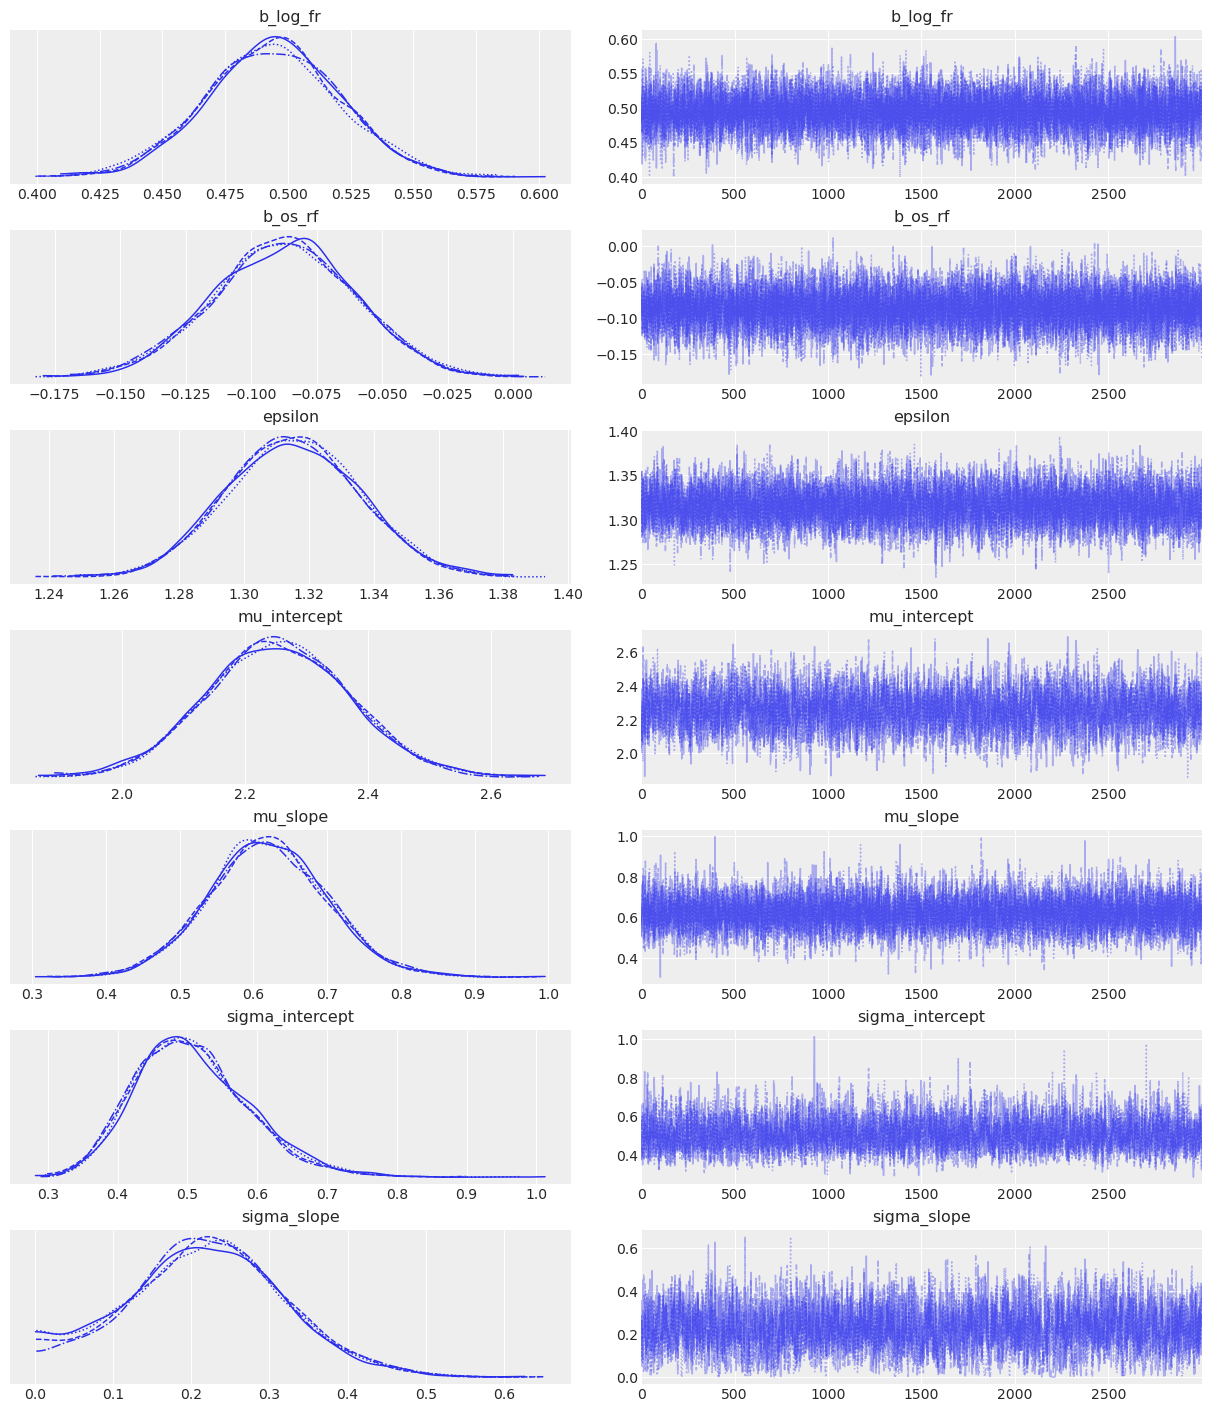

2024-05-29 22:39:36,692 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:36,693 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:36,694 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:36,694 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
2024-05-29 22:39:36,695 | WARNING  | matplotlib.font_manager | _find_fonts_by_props | findfont: Generic family 'serif' not found because none of the following families were found: Computer Mod

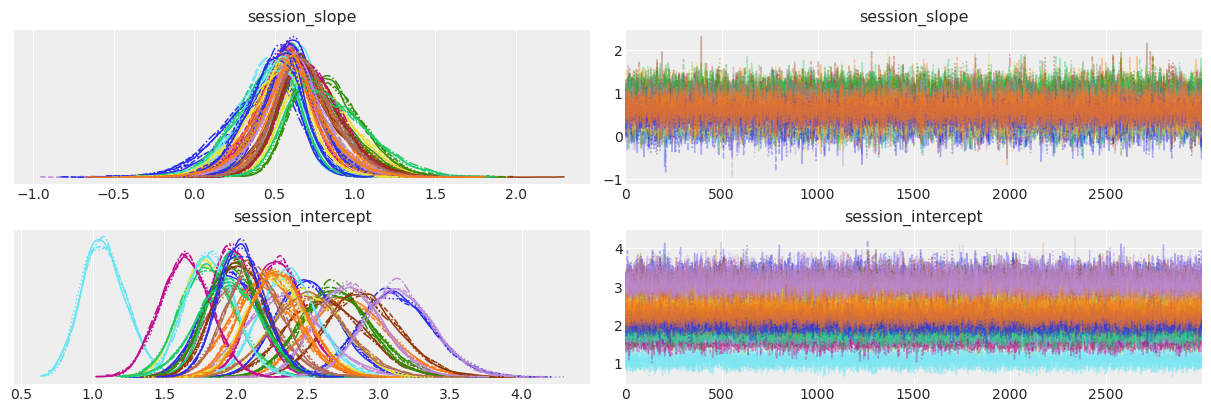

In [8]:
az.summary(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
    ],
    legend=False,
)
# color varies across sessions
az.plot_trace(
    idata,
    var_names=[
        "session_slope",
        "session_intercept",
    ],
    legend=False,
)

  0%|          | 0/9 [00:00<?, ?it/s]

tau_double natural_movie_three
median:  0.6182184843545511
median:  0.21850194817476673
tau_double spontaneous
median:  0.5314600238182664
median:  0.523284438307664
tau_double natural_movie_one_more_repeats
median:  0.4710250166464212
median:  0.34406051896272266
tau_R natural_movie_three
median:  0.7177685497761108
median:  0.4056933347218147
tau_R spontaneous
median:  0.43910772578588403
median:  0.5140279046413243
tau_R natural_movie_one_more_repeats
median:  0.7067269688102228
median:  0.46096420543065
R_tot natural_movie_three
median:  -0.09987403225046458
median:  0.05101782501370221
R_tot spontaneous
median:  -0.05138835906998321
median:  0.057561228729079164
R_tot natural_movie_one_more_repeats
median:  -0.11687958609895877
median:  0.05984080495497667


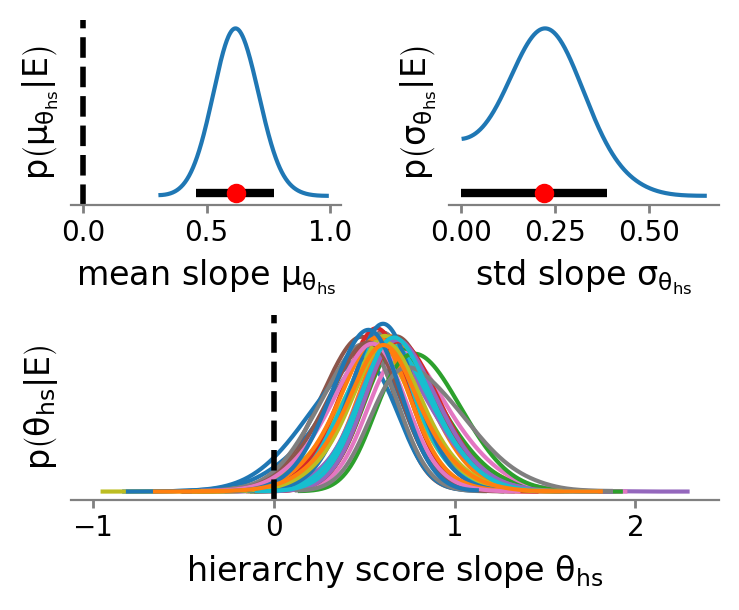

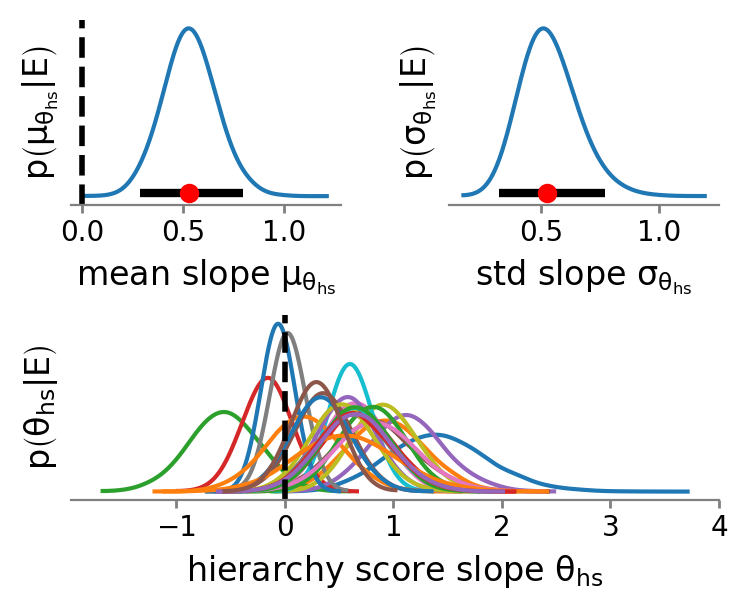

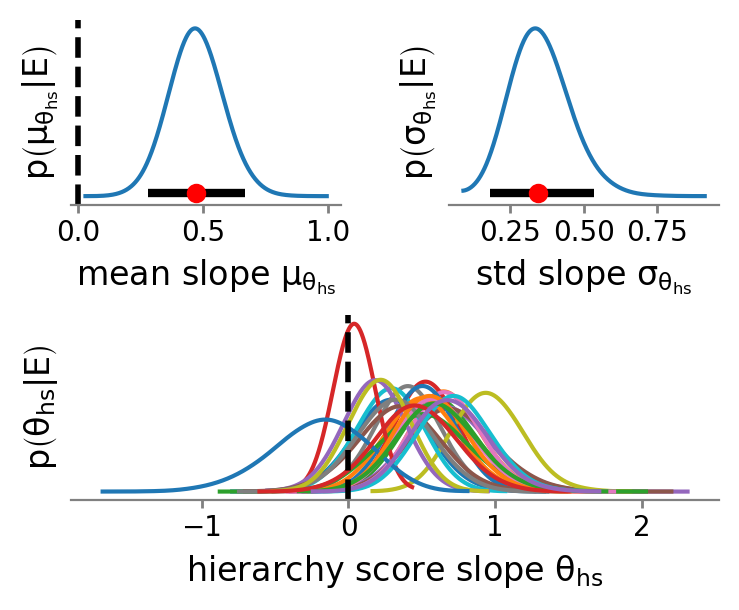

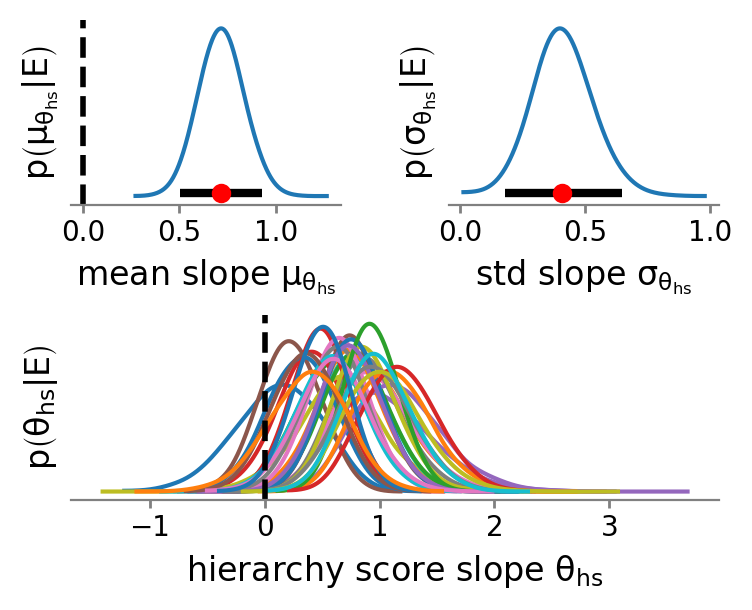

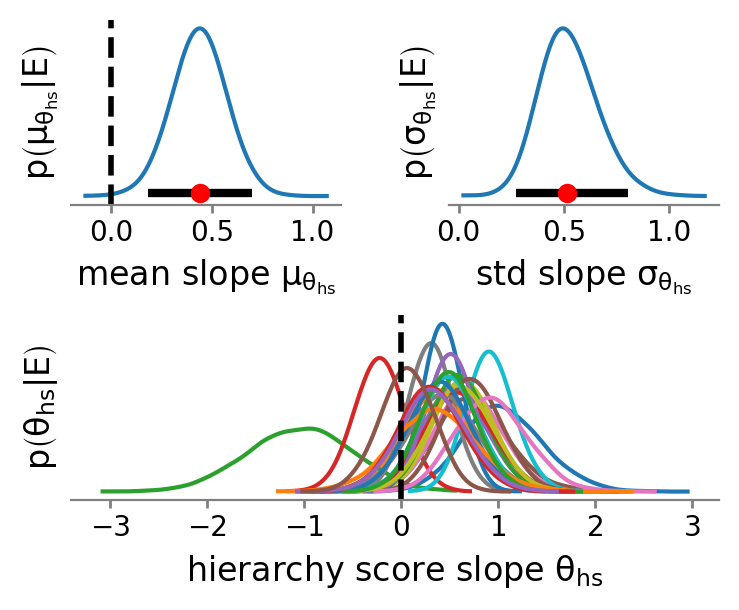

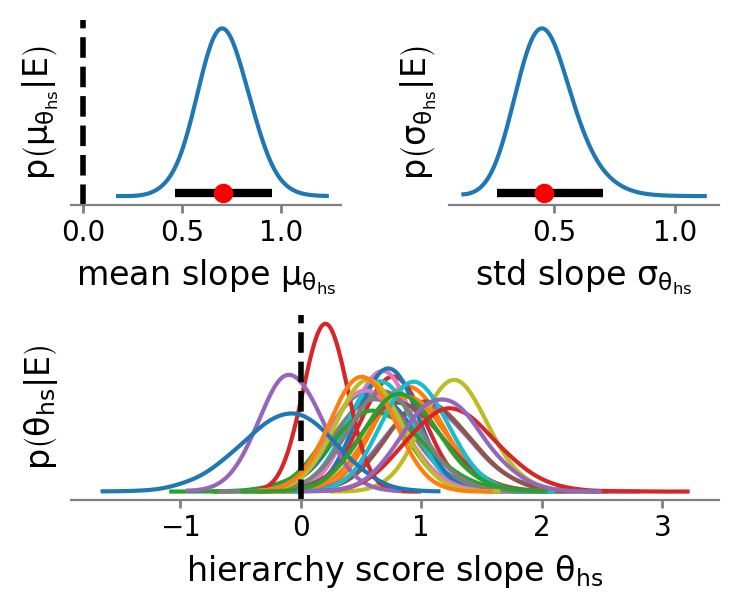

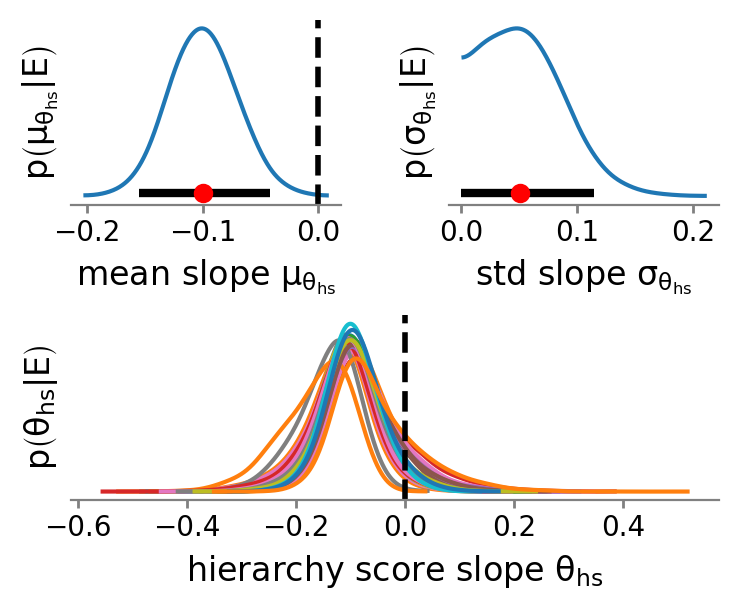

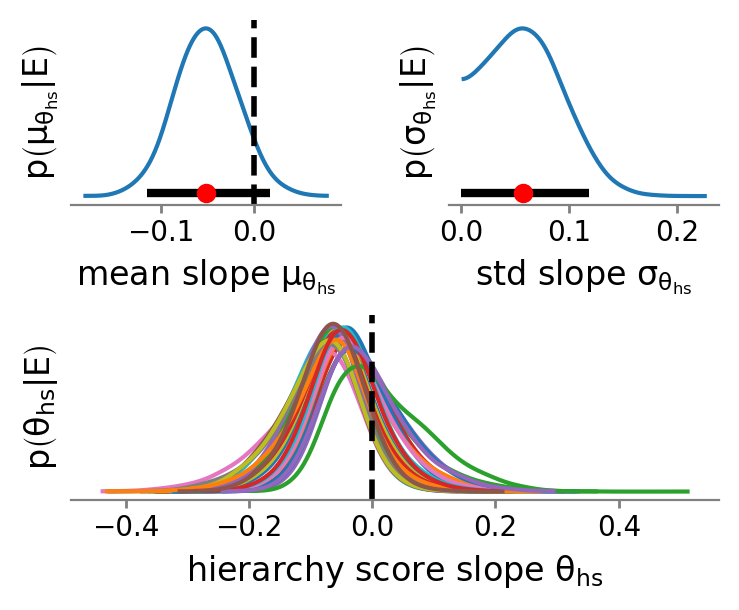

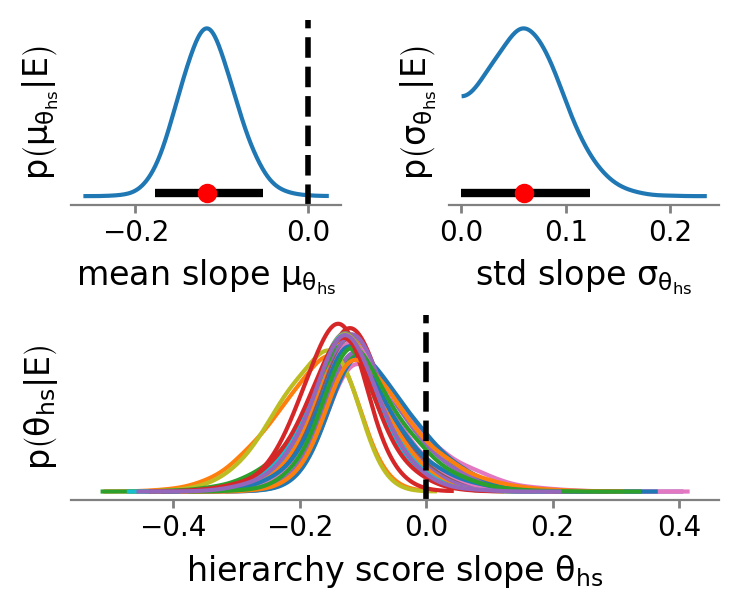

In [56]:
# posterior visualization (hierarchical parameters)

model = "lmm"
measures = ["tau_double", "tau_R", "R_tot"]
stimuli = ["natural_movie_three", "spontaneous", "natural_movie_one_more_repeats"]

combinations = list(product(measures, stimuli))
loos = dict()
rc_kwargs = {
    "xtick.labelsize" : 10,
    "ytick.labelsize" : 10,
    "axes.titlesize" : 12,
    "axes.labelsize" : 12,
    "font.size" : 10,
}

with plt.rc_context(rc_kwargs):
    # Plot hierarchy score posteriors for different measures and stimuli
    for meas, stim in tqdm(combinations):
        print(meas, stim)
        idata = az.from_netcdf(f"{data_dir}/bayes_cortex_{model}_{meas}_{stim}.nc")

        # # TODO: Does this work? If not, see how Paul laoded data posteriors for individual sessions
        # post = idata.posterior.assign_coords(session_idx=idata.constant_data.session_idx)

        # # slope

        fig = plt.figure(figsize=(plot_settings["panel_width"] * 1.7, 3))
        # fig.suptitle(measure_name, ha = "center")
        # fig.suptitle("hierarchy score slope", ha = "center")

        ax1 = plt.subplot(2, 2, 1)
        ax2 = plt.subplot(2, 2, 2)
        ax3 = plt.subplot(2, 1, 2)
        fig.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, hspace=0.6, wspace=0.4)
        # if args.measure == "tau_C":
        #     ax1.set_xlim([-0.05,0.22])
        #     ax3.set_xlim([-0.24,0.44])
        # if args.measure == "tau_R":
        #     ax1.set_xlim([-0.02,0.14])
        #     ax3.set_xlim([-0.12,0.27])
        # if args.measure == "R_tot":
        #     ax1.set_xlim([-0.18,0.06])
        #     ax3.set_xlim([-0.31,0.21])
        if meas == "R_tot":
            bw = 0.01 
        else: 
            bw = 0.05
        ph.plot_posterior(
            idata,
            ax=ax1,
            var_names = ["mu_slope"],
            point_estimate="median",
            hdi_prob=0.95,
            bw=bw,
        )
        ax1.set_xlabel(r"mean slope $\mu_{\theta_{\mathrm{hs}}}$")
        ax1.set_ylabel(r"$p\left(\mu_{\theta_{\mathrm{hs}}} | E\right)$")
        ph.plot_posterior(
            idata,
            ax=ax2,
            var_names=["sigma_slope"],
            point_estimate="median",
            hdi_prob=0.95,
            bw=bw, 
        )
        ax2.set_xlabel(r"std slope $\sigma_{\theta_{\mathrm{hs}}}$")
        ax2.set_ylabel(r"$p\left(\sigma_{\theta_{\mathrm{hs}}} | E\right)$")

        ph.plot_posterior(
            idata,
            ax=ax3,
            var_names=["session_slope"],
            hdi=False,
            bw=bw*2, # plotting session posteriors looks better with higher bandwidth
        )
        ax3.set_xlabel(r"hierarchy score slope $\theta_{\mathrm{hs}}$")
        ax3.set_ylabel(r"$p\left(\theta_{\mathrm{hs}} | E\right)$")

        ax1.axvline(x=0, ls="--", lw=2, color="0.0")
        ax3.axvline(x=0, ls="--", lw=2, color="0.0")

        # for ax in [ax1, ax2, ax3]:
        #     utl.make_plot_pretty(ax)

        fig.savefig(f"../img/bayes_cortex_{model}_hierarchical_posterior_{meas}_{stim}.pdf", bbox_inches="tight", dpi=300)

    # # intercept

    # fig = plt.figure(figsize=(plot_settings["panel_width"] * 1.6, 3))
    # # fig.suptitle(measure_name, ha = "center")
    # # fig.suptitle("intercept", ha = "center")

    # ax1 = plt.subplot(2, 2, 1)
    # ax2 = plt.subplot(2, 2, 2)
    # ax3 = plt.subplot(2, 1, 2)
    # fig0.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, hspace=0.6, wspace=0.3)

    # with model:
    #     utl.plot_posterior(
    #         post["mu_intercept"].values[:, -1000:],
    #         ax=ax1,
    #         point_estimate="median",
    #         hdi_prob=0.95,
    #         transform=f_transf_log_int,
    #     )

    #     ax1.set_xlabel(r"mean intercept $\mu_{\theta_0}$")
    #     ax1.set_ylabel(r"$p\left(\mu_{\theta_0} | E\right)$")
    #     utl.plot_posterior(
    #         post["sigma_intercept"].values[:, -1000:],
    #         ax=ax2,
    #         point_estimate="median",
    #         hdi_prob=0.95,
    #         transform=f_transf_log,
    #     )
    #     ax2.set_xlabel(r"std intercept $\sigma_{\theta_0}$")
    #     ax2.set_ylabel(r"$p\left(\sigma_{\theta_0} | E\right)$")

    #     for session_idx in range(len(sessions)):
    #         utl.plot_posterior(
    #             post["eff_session_intercept"].values[:, -1000:, session_idx],
    #             ax=ax3,
    #             transform=f_transf_int,
    #             hdi=False,
    #             color=sns.color_palette()[session_idx % 10],
    #         )
    #     if args.measure == "R_tot":
    #         ax3.set_xlabel(r"intercept $\exp(\theta_0)$")
    #     else:
    #         ax3.set_xlabel(r"intercept $\exp(\theta_0)$ (ms)")

    #     ax3.set_ylabel(r"$p\left(\theta_0 | E\right)$")
    #     # ax3.set_xlim([-0.55,0.22])

    # for ax in [ax1, ax2, ax3]:
    #     utl.make_plot_pretty(ax)

    # utl.save_plot(
    #     plot_settings,
    #     f"{__file__[:-3]}_posterior_intercept",
    #     allen_bo=args.allen_bo,
    #     stimulus=args.stimulus,
    #     measure=args.measure,
    # )

In [ ]:
## posterior visualization (non-hierarchical parameters)
#%%
from itertools import product
from tqdm.notebook import tqdm

models = ['sgm', 'lm']
measures = ["tau_double", "tau_R", "R_tot"]
stimuli = ["natural_movie_three", "spontaneous", "natural_movie_one_more_repeats"]

combinations = list(product(measures, stimuli, models))
loos = dict()

for meas, stim, model in tqdm(combinations):
    idata = az.from_netcdf(f"{data_dir}/bayes_{model}_{meas}_{stim}.nc")
    loos[f"{model}_{meas}_{stim}"] = az.loo(idata, pointwise=True)

    # Here starts the old plotting script

    if meas == "R_tot":
        n_axes = 3
        fig_height = 4.5
    else:
        n_axes = 4
        fig_height = 6

        
    fig1, axes = plt.subplots(n_axes, 1, figsize=(plot_settings["panel_width"], fig_height))
    fig1.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, hspace=1)
    axes[0].axvline(x=1, ls = "--", lw =2, color = "0.0")    
    axes[1].axvline(x=1, ls = "--", lw =2, color = "0.0")   
    # utl.plot_posterior(trc[-250:], var_names=['mu_intercept'],
    #                    #coords=0,
    #                    ax=axes[0], point_estimate='median',
    #                    hdi_prob=0.95,
    #                    transform=f_transf_int)

    # How does trc relate to idata that we load now? It's the same. Here, only load the last 1000 samples, to ensure that samples are drawn from chains that have converged yet. 
    # can we simply incorporate the old plot function here? Try this out! 
    utl.plot_posterior(trc[-1000:], var_names=[#'b0_intercept',
                                              'b_sign_rf',
                                              #'stimulus[T.spontaneous]',
                                              #'sign_rf[T.True]:stimulus[T.spontaneous]',
                                              # 'firing_rate',
                                              'b_log_fr'],
                       #coords=0,
                       ax=axes[:2], point_estimate='median',
                       hdi_prob=0.95,
                       transform=f_transf)
    utl.plot_posterior(trc[-1000:], var_names=['epsilon'],
                       ax=axes[2], point_estimate='median',
                       hdi_prob=0.95,
                       transform=f_transf_log)
    if not args.measure == "R_tot":
        utl.plot_posterior(trc[-1000:], var_names=['alpha'],
                           ax=axes[3], point_estimate='median',
                           hdi_prob=0.95)
    vars = [r'$\mathrm{θ_{rf}}$', r'$θ_{\log \nu}$', 'ε', r'$\alpha$']
    var_names = [r'$\exp(\mathrm{θ_{rf}})$ (responsiveness)', r'$\exp(θ_{\log \nu})$ (log fir. rate)', 'ε (scale)', r'$\alpha$ (shape)']
    for ax, var, var_name in zip(axes, vars[:n_axes], var_names[:n_axes]):
#'$θ_0$ (no rf, fir. rate={:.2f}Hz)'.format(10**np.mean(data['log_fr'])),
        #ax.set_xlabel(var)
        ax.set_ylabel('p({} | E)'.format(var))
        #ax.set_title(var_name)
        ax.set_xlabel(var_name)
        ax.set_title('')
        utl.make_plot_pretty(ax)

    axes[0].set_title(measure_name, ha='center')
    #axes[0].set_xticks([0.06, 0.065])
    #axes[1].set_xticks([-0.075, -0.08, -0.004])
    #axes[2].set_xticks([-0.012, -0.008, -0.004])
    #axes[3].set_xticks([-0.015, -0.01, -0.005])
    #axes[4].set_xticks([0.45, 0.5])
    #axes[5].set_xticks([0.048, 0.049, 0.05])

utl.save_plot(plot_settings, f"{__file__[:-3]}_posterior", allen_bo=args.allen_bo, stimulus=args.stimulus, measure=args.measure)

# with model:
#     fig0, ax0 = plt.subplots(1, 1, figsize=(plot_settings["panel_width"], 2))
#     fig0.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, hspace=1)
#
#     utl.plot_posterior(trc[-250:], var_names=['mu_area'],
#                        ax=ax0, point_estimate='median',
#                        hdi_prob=0.95,
#                        transform=f_transf)
#
#     ax0.set_ylabel('p({$θ_3$} | E)')
#     ax0.set_xlabel('$θ_3$ (hier. score)')
#     ax0.set_title('')
#     utl.make_plot_pretty(ax0)
#
#     axes[0].set_title(measure_name, ha='center')
#
# utl.save_plot(plot_settings, f"{__file__[:-3]}_posterior_hierarchy_score", measure=args.measure)

